In [5]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [6]:
df=pd.read_csv("sales_forecasting.csv", encoding="latin1")

In [7]:
df['Ship Date']= pd.to_datetime(df['Ship Date'])
df['Order Date']= pd.to_datetime(df['Order Date'])

📈 Monthly Sales Forecast with XGBoost
Root Mean Squared Error (RMSE): 12046.19
R² Score (Accuracy): 74.44%


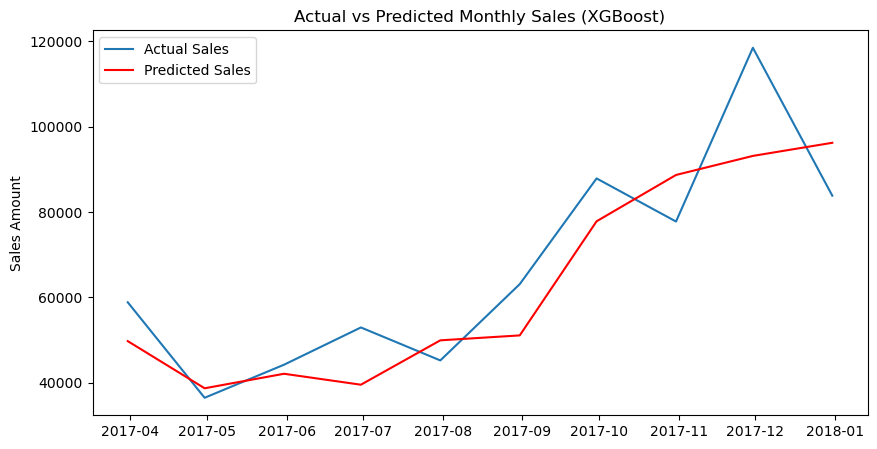

In [8]:
# Group Sales by Month
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Order Date')

# Feature Engineering
monthly_sales['Month'] = monthly_sales['Order Date'].dt.month
monthly_sales['Year'] = monthly_sales['Order Date'].dt.year
monthly_sales['Sales_Lag1'] = monthly_sales['Sales'].shift(1)
monthly_sales['Sales_Lag2'] = monthly_sales['Sales'].shift(2)
monthly_sales['RollingMean3'] = monthly_sales['Sales'].rolling(window=3).mean()
monthly_sales = monthly_sales.fillna(0)

# Features & Target
X = monthly_sales[['Month', 'Year', 'Sales_Lag1', 'Sales_Lag2', 'RollingMean3']]
y = monthly_sales['Sales']

# Train-Test Split (No shuffle for time series)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ---------------- Train XGBoost for Monthly Forecast ----------------

model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# ---------------- Evaluate ----------------

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("📈 Monthly Sales Forecast with XGBoost")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score (Accuracy): {r2:.2%}")

# ---------------- Visualize ----------------

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(monthly_sales['Order Date'][-len(y_test):], y_test, label="Actual Sales")
ax.plot(monthly_sales['Order Date'][-len(y_test):], y_pred, label="Predicted Sales", color='red')
ax.set_title("Actual vs Predicted Monthly Sales (XGBoost)")
ax.set_ylabel("Sales Amount")
ax.legend()

